# module import

In [1]:
import os
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore")

# Visualize
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# Verify
from scipy import stats

### Read Data

In [2]:
data_path = "../3. 경서경욱_데이터 및 모델 세이브 파일/dataset/"

demo = pd.read_csv(data_path+"LPOINT_BIG_COMP_01_DEMO.csv")          # 고객 데모 정보 
pdde = pd.read_csv(data_path+"LPOINT_BIG_COMP_02_PDDE.csv")          # 유통사 상품 구매 내역
clac = pd.read_csv(data_path+"LPOINT_BIG_COMP_04_PD_CLAC.csv")       # 유통사 상품 카테고리 마스터
br = pd.read_csv(data_path+"LPOINT_BIG_COMP_05_BR.csv")              # 유통사/제휴사 점포 마스터
cop = pd.read_csv(data_path+"LPOINT_BIG_COMP_03_COP_U.csv")          # 제휴사 서비스 이용 내역
lpay = pd.read_csv(data_path+"LPOINT_BIG_COMP_06_LPAY.csv")          # 엘페이 결제내역

In [3]:
pdde.br_c.fillna('ONLINE', inplace=True)

trade = pdde.groupby(['cust','cop_c','chnl_dv','br_c','de_dt','de_hr'])\
        .agg({'pd_c':[('상품종류수', pd.Series.nunique)],'buy_am':[('금액', sum)],'buy_ct':[('수량', sum)]})
trade.columns = trade.columns.get_level_values(1) ; trade.reset_index(inplace=True)

trade['date'] = pd.to_datetime(trade['de_dt'].astype(str)+' '+trade['de_hr'].astype(str).str.zfill(2))
trade['de_dt'] = pd.to_datetime(trade['de_dt'], format='%Y%m%d')
del trade['de_hr']

### $\blacktriangleright$ 오프라인/온라인 거래 비교

- 오프라인/온라인 비율<br>
  연관상품추천, 잠재요인분석은 온라인에서 제공할 것이다. 온라인이 활성화된 데이터셋을 확인한다.

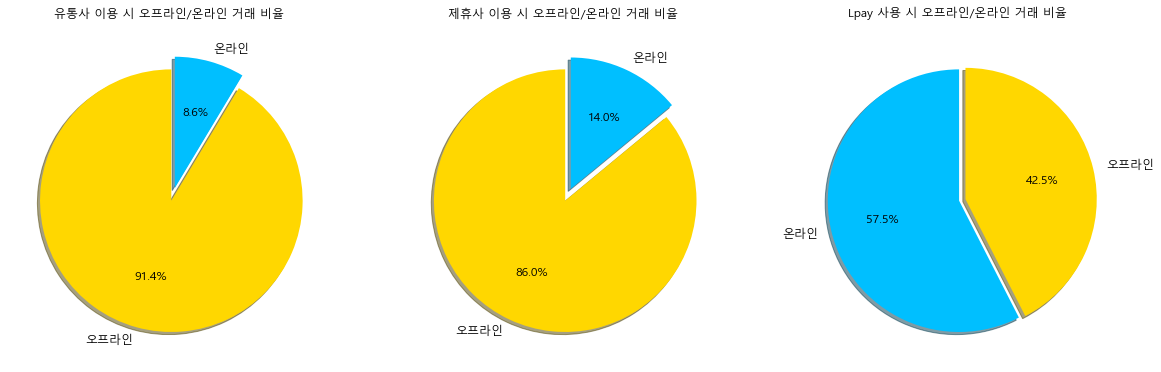

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,8))

ease = trade['chnl_dv'].value_counts().rename(index={1:'오프라인',2:'온라인'}).reset_index()
ax[0].pie(ease['chnl_dv'], labels=ease['index'], 
        startangle=90, autopct="%1.1f%%", explode=[0, 0.1], shadow=True, textprops={'fontsize': 12}, colors=['gold','deepskyblue'])
ax[0].set_title("유통사 이용 시 오프라인/온라인 거래 비율 \n")

ease = cop.chnl_dv.value_counts().rename(index={1:'오프라인',2:'온라인'}).reset_index()
ax[1].pie(ease['chnl_dv'], labels=ease['index'], 
        startangle=90, autopct="%1.1f%%", explode=[0, 0.1], shadow=True, textprops={'fontsize': 12}, colors=['gold','deepskyblue'])
ax[1].set_title("제휴사 이용 시 오프라인/온라인 거래 비율 \n")

ease = lpay.chnl_dv.value_counts().rename(index={1:'오프라인',2:'온라인'}).reset_index()
ax[2].pie(ease['chnl_dv'], labels=ease['index'], 
        startangle=90, autopct="%1.1f%%", explode=[0, 0.05], shadow=True, textprops={'fontsize': 12}, colors=['deepskyblue', 'gold'])
ax[2].set_title("Lpay 사용 시 오프라인/온라인 거래 비율 \n")
plt.show()

- pdde 오프라인/온라인 일별 매출, 판매수량<br>
  상품 정보가 담긴 pdde 데이터에서 오프라인/온라인에 따라 일별 매출, 판매수량이 차이가 날지 확인한다.

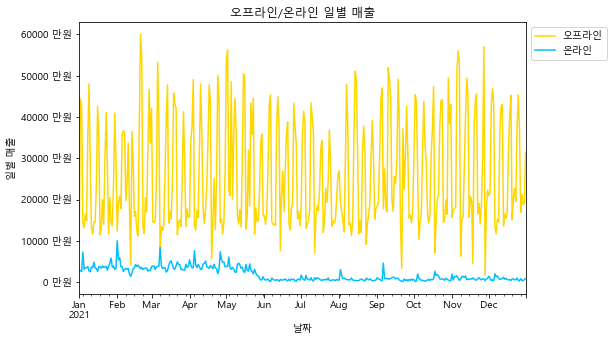

In [5]:
ease = pd.pivot_table(trade, index='de_dt', columns='chnl_dv', values='금액', aggfunc=sum) / 10000
ease.plot(title="오프라인/온라인 일별 매출", color=['gold','deepskyblue'], figsize=(8,5))
plt.xlabel("날짜")
plt.ylabel("일별 매출")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i 만원'))
plt.legend(['오프라인','온라인'], bbox_to_anchor=(1,1))
plt.show()

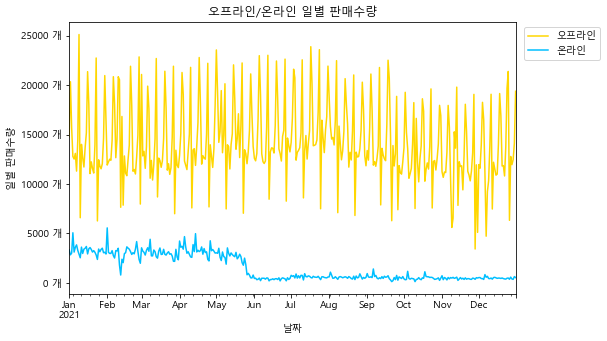

In [6]:
ease = pd.pivot_table(trade, index='de_dt', columns='chnl_dv', values='수량', aggfunc=sum)
ease.plot(title="오프라인/온라인 일별 판매수량", color=['gold','deepskyblue'], figsize=(8,5))
plt.xlabel("날짜")
plt.ylabel("일별 판매수량")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i 개'))
plt.legend(['오프라인','온라인'], bbox_to_anchor=(1.2,1))
plt.show()

- MZ세대와 비MZ세대 비교<br>
  『강윤지, 김상훈 (2022), "기업의 ESG 경영에 대한 소비자 인식에 관한 연구 : MZ세대를 중심으로", 광고학연구 제33권 제3호, p.7-39』는<br>
  비MZ세대가 MZ세대에 비해 ESG 경영에 대한 인식이 높으나 ESG 경영에 참여율이 높은 건 MZ세대라 밝혔다. 그리고 그 이유를 MZ세대는 소셜미디어, IT인프라를 활발히 사용해 온라인 공간에서 사회적 문제에 자주 접하고 정보를 쉽게 얻을 수 있는 반면에 비MZ세대는 그렇지 못함을 꼽았다.<br>
  MZ세대의 온라인 활동이 활발한 지 살펴본다.

In [5]:
# MZ 구분
# MZ세대는 1980년 이후 출생자로 2021년 당시 42세 이하의 고객들이다.
trade = pd.merge(trade, demo.rename(columns={'zon_hlv':'거주지'}), on='cust')
trade['MZ'] = trade['ages'].apply(lambda x: 1 if int(x[0]) < 4 else 0)

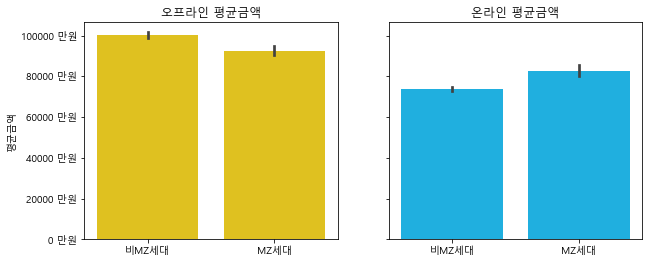

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
sns.barplot(data=trade.query('chnl_dv==1'), x='MZ', y='금액', ax=ax[0], color='gold')
sns.barplot(data=trade.query('chnl_dv==2'), x='MZ', y='금액', ax=ax[1], color='deepskyblue')
ax[0].set_title("오프라인 평균금액")
ax[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%i 만원'))
ax[1].set_title("온라인 평균금액")
plt.xticks([0,1],['비MZ세대','MZ세대'])
ax[0].set_xlabel('');ax[1].set_xlabel('')
ax[0].set_ylabel("평균금액");ax[1].set_ylabel('')
plt.show()

- 상품추천 적합성<br>
  온라인에서 상품추천을 제공하고자 하는 프로젝트 목표에 맞게 온라인에서 여러 종류의 상품을 구매할 시 구매수량이 큰 지 확인한다.

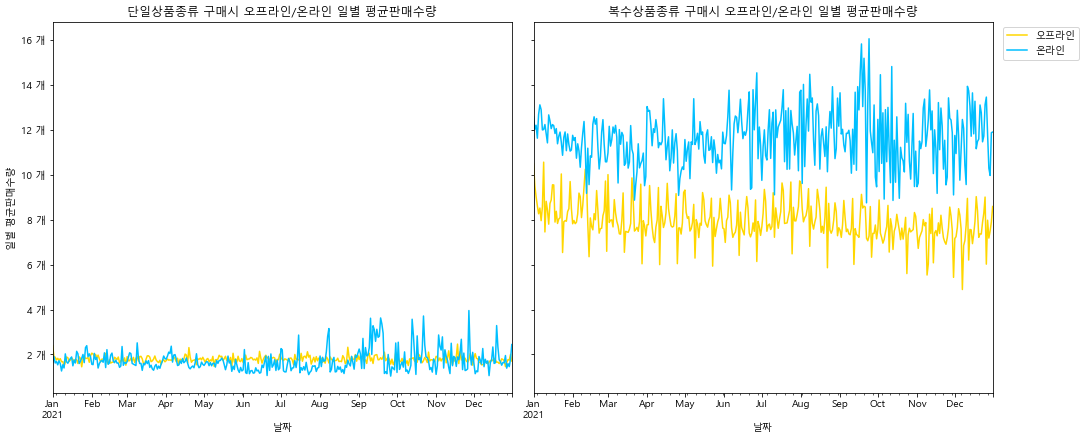

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True, constrained_layout=True)
ease = pd.pivot_table(trade.query('상품종류수==1'), index='de_dt', columns='chnl_dv', values='수량', aggfunc=np.mean)
ease.plot(title="단일상품종류 구매시 오프라인/온라인 일별 평균판매수량", color=['gold','deepskyblue'], ax=ax[0], legend=False)
ax[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%i 개'))
ax[0].set_xlabel("날짜")
ax[0].set_ylabel("일별 평균판매수량")

ease = pd.pivot_table(trade.query('상품종류수 > 1'), index='de_dt', columns='chnl_dv', values='수량', aggfunc=np.mean)
ease.plot(title="복수상품종류 구매시 오프라인/온라인 일별 평균판매수량", color=['gold','deepskyblue'], ax=ax[1])
ax[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%i 개'))
ax[1].set_xlabel("날짜")
ax[1].set_ylabel("일별 평균판매수량")
ax[1].legend(['오프라인','온라인'], bbox_to_anchor=(1.2,1))
plt.show()

In [6]:
offline = pd.merge(trade, br.rename(columns={'zon_hlv':'매장위치'}), on=['br_c','cop_c'])

ease = offline[offline['거주지']==offline['매장위치']]
ease['거주지내구매'] = 1

offline = pd.merge(offline, ease['거주지내구매'], left_index=True, right_index=True, how='outer')
offline['거주지내구매'].fillna(0, inplace=True)

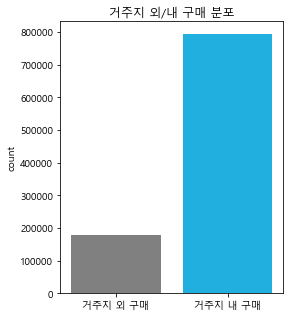

In [11]:
plt.figure(figsize=(4,5))
sns.countplot(data=offline, x='거주지내구매', palette=['gray','deepskyblue'])
plt.title("거주지 외/내 구매 분포")
plt.xticks([0,1],['거주지 외 구매', '거주지 내 구매'])
plt.xlabel('')
plt.show()

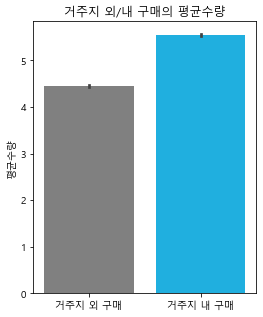

In [12]:
plt.figure(figsize=(4,5))
sns.barplot(data=offline, x='거주지내구매', y='수량', palette=['gray','deepskyblue'])
plt.title("거주지 외/내 구매의 평균수량")
plt.xticks([0,1],['거주지 외 구매', '거주지 내 구매'])
plt.xlabel('')
plt.ylabel("평균수량")
plt.show()

### $\blacktriangleright$ 온라인 첫구매 이후 변화
고객의 온라인 첫 결제 이후 1)오프라인 거래의 비중이 줄었는가, 2)오프라인 거래의 비중과 온라인 결제간의 음의 상관관계가 성립하는가를 살펴보고자 한다.<br>
우리는 앞의 **[온라인 첫결제]**에서 고객들의 온라인 첫 구매시점이 상이하다는 것을 확인했다. 시간간격이 짧아 거래가 적게 , 시간간격이 길어 거래가 많이 발생하는 것이 필연적인데 고객별로 첫 거래일부터 온라인 첫결제일간의 간격, 온라인 첫결제일부터 마지막 거래일간의 간격이 상이함은 오프라인 거래의 비중을 단순히 $\frac{\text{온라인 첫결제 이후 오프라인 거래수}}{\text{온라인 첫결제 이전 오프라인 거래수}}$로 구할 수 없게 한다. 이에 온라인 첫결제 이전, 이후의 시간간격을 반영하여 시간당 오프라인 거래수 비중, $\large\frac{\frac{\text{온라인 첫결제 이후 오프라인 거래수}}{\text{온라인 첫결제 이후 시간기간}}}{\frac{\text{온라인 첫결제 이전 오프라인 거래수}}{\text{온라인 첫결제 이전 시간기간}}}$를 지표로 사용한다.

In [12]:
# 온라인 거래를 한 고객들의 최초 구매일을 구한다.
first_onday = trade.query('chnl_dv == 2').groupby('cust')['date'].min()

# 온라인 거래를 한 고객들의 구매데이터만 분석한다.
ease = pd.merge(trade, first_onday.reset_index().rename(columns={'date':'firstday'}), on='cust')

# 일자를 비교해 이전, 당일, 이후 구매한 데이터를 분리한다.
before, Dday, after = ease[ease['date'] < ease['firstday']], ease[ease['date'] == ease['firstday']], ease[ease['date'] > ease['firstday']]

In [13]:
print('온라인 이용고객수: ', Dday.cust.nunique())
print('- 온라인 첫결제 이전에만 결제가 존재하는 고객수: ', len(set(before.cust.unique()) - set(after.cust.unique())))
print('- 온라인 첫결제 전후로 결제가 존재하는 고객수: ', len(set(before.cust.unique()) & set(after.cust.unique())))
print('- 온라인 첫결제 이후에만 결제가 존재하는 고객수: ', len(set(after.cust.unique()) - set(before.cust.unique())))
print('- 온라인 첫결제가 유일한 거래인 고객수: ', len(set(Dday.cust.unique())^(set(before.cust.unique())|set(after.cust.unique()))))

온라인 이용고객수:  9466
- 온라인 첫결제 이전에만 결제가 존재하는 고객수:  112
- 온라인 첫결제 전후로 결제가 존재하는 고객수:  5248
- 온라인 첫결제 이후에만 결제가 존재하는 고객수:  3700
- 온라인 첫결제가 유일한 거래인 고객수:  406


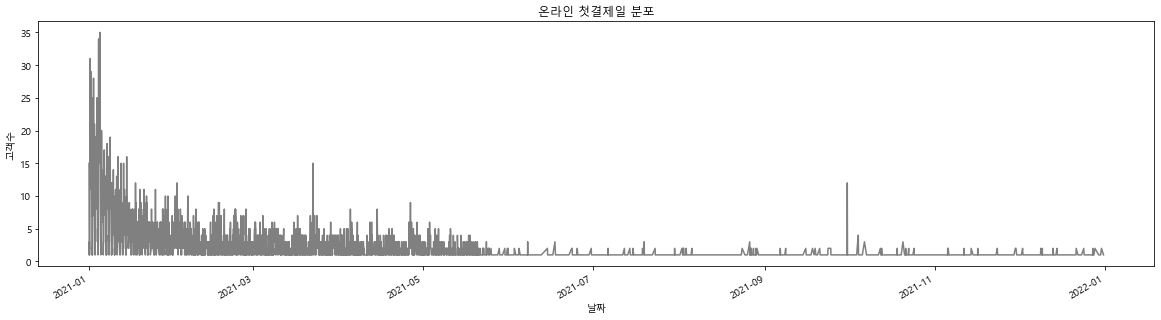

In [16]:
Dday.query('chnl_dv==2').groupby('date')['cust'].nunique().plot(title="온라인 첫결제일 분포", figsize=(20,5), color='gray')
plt.xlabel("날짜")
plt.ylabel("고객수")
plt.show()

In [17]:
# 온라인 구매 이전과 이후 간의 변화를 보고싶은 것으로 이전, 이후에 거래가 발생한 구매데이터만 분석한다.
sample = set(before.cust.unique()) & set(after.cust.unique())
sample_bef = before.query('cust in @sample')
sample_af = after.query('cust in @sample')

In [18]:
sample_value = pd.merge(pd.pivot_table(sample_bef, index='cust', columns='chnl_dv', 
                                       values='금액', aggfunc=np.size, fill_value=0).rename(columns={1:'before_1'}),
                        pd.pivot_table(sample_af, index='cust', columns='chnl_dv', 
                                       values='금액', aggfunc=np.size, fill_value=0).rename(columns={1:'after_1',2:'online'}),
                        left_index=True, right_index=True, how='inner')

# 시간간격 추출
ease = pd.merge(trade.query('cust in @sample').groupby('cust')['date'].agg([min, max]),
                first_onday, left_index=True, right_index=True, how='inner')
ease['before_hours'], ease['after_hours'] = (ease['date'] - ease['min']).dt.total_seconds()/(60*60), \
                                            (ease['max'] - ease['date']).dt.total_seconds()/(60*60)
sample_value = pd.merge(sample_value, ease[['before_hours','after_hours']], left_index=True, right_index=True)

# 시간당 오프라인 거래수 비중
sample_value['offline_prob'] = (sample_value['after_1']/sample_value['after_hours'])\
                                /(sample_value['before_1']/sample_value['before_hours'])

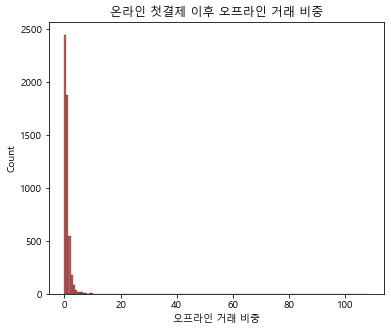

In [19]:
# 대체로 온라인 첫결제 이후 시간당 오프라인 거래수 비중이 감소한다.
# 온라인 거래로의 유입은 오프라인 거래를 감소시킬 것이다.
plt.figure(figsize=(6,5))
sns.histplot(data=sample_value['offline_prob'], bins=150, color="brown")
plt.title("온라인 첫결제 이후 오프라인 거래 비중")
plt.xlabel("오프라인 거래 비중")
plt.show()

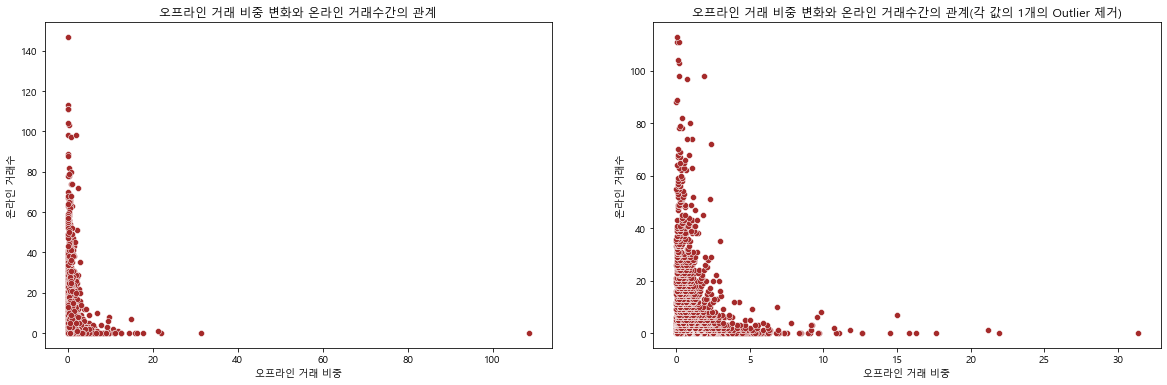

In [20]:
# 오프라인 거래 비중이 줄수록 온라인 거래수는 커지는 관계를 갖는다.
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.scatterplot(data=sample_value, x='offline_prob', y='online', color='brown', ax=ax[0])
ax[0].set_title("오프라인 거래 비중 변화와 온라인 거래수간의 관계")
ax[0].set_xlabel("오프라인 거래 비중")
ax[0].set_ylabel("온라인 거래수")

sns.scatterplot(data=sample_value.sort_values('offline_prob').iloc[:-1].sort_values('online').iloc[:-1], 
                x='offline_prob', y='online', color='brown', ax=ax[1])
ax[1].set_title("오프라인 거래 비중 변화와 온라인 거래수간의 관계(각 값의 1개의 Outlier 제거)")
ax[1].set_xlabel("오프라인 거래 비중")
ax[1].set_ylabel("온라인 거래수")
plt.show()

In [21]:
# online, offline_prob 각각의 눈에 띄는 1개의 Outlier들을 제외하고 상관관계 검증을 시도한다.
test = sample_value.sort_values('online').iloc[:-1].sort_values('offline_prob').iloc[:-1]

# p-value가 0.05보다 작아 귀무가설, 정규분포를 갖는다가 기각되면 spearman correlation 검증을 시도한다.
# 반대로 귀무가설을 채택하면 pearson correlation 검증을 시도한다.
norm_x, norm_y= stats.shapiro(test.online), stats.shapiro(test.offline_prob)
if (norm_x[1] > 0.05) & (norm_y[1] > 0.05):
    print(f'online_norm: {norm_x[0]}, offline_prob_norm: {norm_y[0]}')
    corr, p = stats.pearsonr(test['online'], test['offline_prob'])
    print(f'Pearson Correlation: {corr}, P-value: {p}')
else:
    corr, p = stats.spearmanr(test['online'], test['offline_prob'])
    print(f'Spearman Correlation: {corr}, P-value: {p}')

Spearman Correlation: -0.22835644114079842, P-value: 4.980343683187648e-63


- 시간당 오프라인 거래수 변화, 온라인 거래수가 정규분포를 갖지 않아 Spearman 상관검증을 한 결과 p-value가 0.05보다 매우 작으며 유의미한 음의 상관관계를 가짐을 확인할 수 있다.